In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
# !cp -r drive/MyDrive/put_jetbot_dataset /content/
!cp -r drive/MyDrive/camera /content/
# !rm -r /content/put_jetbot_dataset
# !pip install tf2onnx
# !pip install tensorflow_addons
# !pip install keras.src.engine

In [60]:
import os
import gc
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from pathlib import Path
from typing import Generator

from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary


Using device: cuda
Loading training data
Loading validation data
Loading test data
Number of training samples: 9352
Number of validation samples: 778
Number of test samples: 2489
Model architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           2,432
         MaxPool2d-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
 AdaptiveAvgPool2d-6            [-1, 128, 4, 4]               0
            Linear-7                  [-1, 128]         262,272
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 64]           8,256
           Linear-10                    [-1, 2]             130
Total params: 365,442
Trainable 

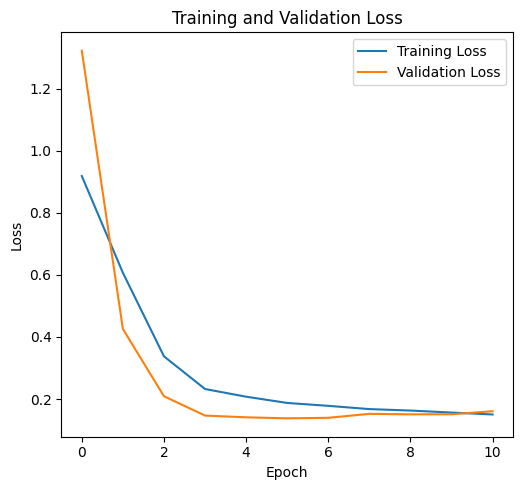

Training completed successfully!


In [62]:
# Set random seed for reproducibility
random_state = 44 # A imie jego czterdziesci i cztery
random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


def load_data(csv_paths) -> Generator[np.array, float, float]:
    for csv_path in csv_paths:
        csv_data = pd.read_csv(csv_path, header=None)
        csv_data.columns = ["filename", "forward", "left"]

        # This means our data, so we don't have extreme values (as dataset is
        #  made by students, therefore not perfect)
        csv_data = csv_data.rolling(window=5, min_periods=1, center=True).mean()

        image_paths = glob(f"{csv_path.removesuffix('.csv')}/*.jpg")
        random.shuffle(image_paths)

        for image_path in image_paths:
            image_data = cv2.imread(image_path)
            if image_data is None:
                continue
            image_number = int(Path(image_path).name.removesuffix(".jpg"))
            row = csv_data[csv_data["filename"]==image_number]
            if row.empty:
                continue
            yield image_data, row["forward"].values[0], row["left"].values[0]

class DrivingDataset(Dataset):
    def __init__(self, csv_paths, image_size=64, augment=True):
        self.data = []
        self.image_size = image_size
        self.augment = augment

        for image, forward, left in load_data(csv_paths):
            # Preprocess original image
            processed_img = self.preprocess_image(image)
            self.data.append((processed_img, [forward, left]))

            # Add augmented version
            if augment:
                augmented_img, forward_aug, left_aug = self.augment_data(processed_img, forward, left)
                self.data.append((augmented_img, [forward_aug, left_aug]))

    def preprocess_image(self, image):
        """
        Preprocessing function to images.
        Applies resize, CLAHE, and Gaussian blur.
        Normalizes to [0, 1] and converts to PyTorch format (C, H, W).
        Returns preprocessed image.
        """

        # Resize image
        image = cv2.resize(image, (self.image_size, self.image_size))

        # Apply CLAHE enhancement
        img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10))

        y, u, v = cv2.split(img_yuv)
        y_clahe = clahe.apply(y)
        img_clahe = cv2.merge((y_clahe, u, v))
        img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_YUV2BGR)

        # Apply Gaussian blur
        img_blurred = cv2.GaussianBlur(img_clahe, (3, 3), 0)

        # Normalize to [0, 1]
        img_blurred = img_blurred.astype(np.float32) / 255.0

        # Convert to PyTorch format (C, H, W)
        img_blurred = np.transpose(img_blurred, (2, 0, 1))

        return img_blurred

    def augment_data(self, image, forward, left):
        """
        Applies randomly color jitter. Flips image horizontally.
        Returns augmented image, forward and left values.
        """
        # # Convert back to (H, W, C) for flipping
        image_hwc = np.transpose(image, (1, 2, 0))
        if np.random.random() > 0.5:  # 50% chance to apply color jitter
          image = self.add_color_jitter(image_hwc)

        # Flipping image horizontally to get more data.
        image_flipped = cv2.flip(image_hwc, 1)
        # # Convert back to (C, H, W)
        image_flipped = np.transpose(image_flipped, (2, 0, 1))
        left_flipped = -left
        forward_flipped = forward

        return image_flipped, forward_flipped, left_flipped

    def add_color_jitter(self, image):
        """
        Color jitter for augumentation.
        Randomly adjust brightness, contrast, and saturation of the image.
        Applied on range [0,1]
        Returns image with applied jitter.
        """
        brightness = np.random.uniform(-0.2, 0.2)
        contrast = np.random.uniform(0.8, 1.2)
        saturation = np.random.uniform(0.8, 1.2)
        # Apply brightness, contrast, saturation in HSV
        image = image + brightness
        image = (image - 0.5) * contrast + 0.5
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv[:, :, 1] *= saturation  # Saturation channel
        image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        # Clip to valid range
        image = np.clip(image, 0, 1)
        return image

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, labels = self.data[idx]
        return torch.FloatTensor(image), torch.FloatTensor(labels)

class ModifiedNvidiaNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.avgpool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        return self.output(x)

def weighted_mse_loss(forward_weight=3.0, left_weight=7.0):
    """
    Per dimension MSE using weights as ternsor for each dimension.
    torch.tensor creates tensor for weights
    torch.mean applies MSE per dimension
    torch.dot applies weights
    Ensured device compatibility
    """
    weights = torch.tensor([forward_weight, left_weight])

    def loss_fn(y_pred, y_true):
        mse_per_dim = torch.mean((y_true - y_pred) ** 2, dim=0)
        return torch.dot(weights.to(y_pred.device), mse_per_dim)

    return loss_fn

def train_model(model, train_loader, val_loader, num_epochs=40, lr=0.001):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = weighted_mse_loss(forward_weight=1.0, left_weight=3.0)

    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    best_model_state = None

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_forward_mse = 0.0
        train_left_mse = 0.0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate individual MSEs
            with torch.no_grad():
                forward_mse = torch.mean(torch.square(target[:, 0] - output[:, 0]))
                left_mse = torch.mean(torch.square(target[:, 1] - output[:, 1]))
                train_forward_mse += forward_mse.item()
                train_left_mse += left_mse.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_forward_mse = 0.0
        val_left_mse = 0.0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()

                # Calculate individual MSEs
                forward_mse = torch.mean(torch.square(target[:, 0] - output[:, 0]))
                left_mse = torch.mean(torch.square(target[:, 1] - output[:, 1]))
                val_forward_mse += forward_mse.item()
                val_left_mse += left_mse.item()

        # Average losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_forward_mse /= len(train_loader)
        train_left_mse /= len(train_loader)
        val_forward_mse /= len(val_loader)
        val_left_mse /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Forward MSE: {train_forward_mse:.4f}, Train Left MSE: {train_left_mse:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Forward MSE: {val_forward_mse:.4f}, Val Left MSE: {val_left_mse:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses

def evaluate_model(model, test_loader):
    model.eval()
    y_true_list = []
    y_pred_list = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            y_true_list.append(target.cpu().numpy())
            y_pred_list.append(output.cpu().numpy())

    y_true_all = np.vstack(y_true_list)
    y_pred_all = np.vstack(y_pred_list)

    # Compute metrics
    total_mse = mean_squared_error(y_true_all, y_pred_all)
    mse_forward = mean_squared_error(y_true_all[:, 0], y_pred_all[:, 0])
    mse_left = mean_squared_error(y_true_all[:, 1], y_pred_all[:, 1])

    print("Test Results:")
    print(f"Total MSE: {total_mse:.4f}")
    print(f"MSE Forward: {mse_forward:.4f}")
    print(f"MSE Left: {mse_left:.4f}")

    return total_mse, mse_forward, mse_left

# Main execution
if __name__ == "__main__":
    # Load data paths
    csv_paths = glob("/content/put_jetbot_dataset/dataset/*.csv")
    random.shuffle(csv_paths)

    test_paths = csv_paths[:3]
    val_path = [csv_paths[3:][0]]
    train_paths = csv_paths[3:][1:]

    img_size = 128
    batch_size = 16

    # Create datasets
    print("Loading training data")
    train_dataset = DrivingDataset(train_paths, image_size=img_size, augment=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    print("Loading validation data")
    val_dataset = DrivingDataset(val_path, image_size=img_size, augment=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    print("Loading test data")
    test_dataset = DrivingDataset(test_paths, image_size=img_size, augment=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(val_dataset)}")
    print(f"Number of test samples: {len(test_dataset)}")

    # Create and train model
    model = ModifiedNvidiaNetwork()
    print("Model architecture:")
    model.to(device)
    summary(model, input_size=(3, img_size, img_size))

    # Train the model
    print("\nStarting training...")
    model, train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20)

    # Save the model
    torch.save(model.state_dict(), 'nvidia_preprocessing_clash1.pth')
    print("Model saved as 'nvidia_preprocessing_clash1.pth'")

    # Export to ONNX
    try:
        model.eval()
        dummy_input = torch.randn(1, 3, 64, 64).to(device)
        torch.onnx.export(model, dummy_input, "models_onnx/nvidia_preprocessing_clash1.onnx",
                         input_names=['input'], output_names=['output'],
                         dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})
        print("Model exported to ONNX format")
    except Exception as e:
        print(f"ONNX export failed: {e}")

    # Test the model
    print("\nEvaluation on test set:")
    total_mse, mse_forward, mse_left = evaluate_model(model, test_loader)

    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("Training completed successfully!")

Found 7 images in /camera/


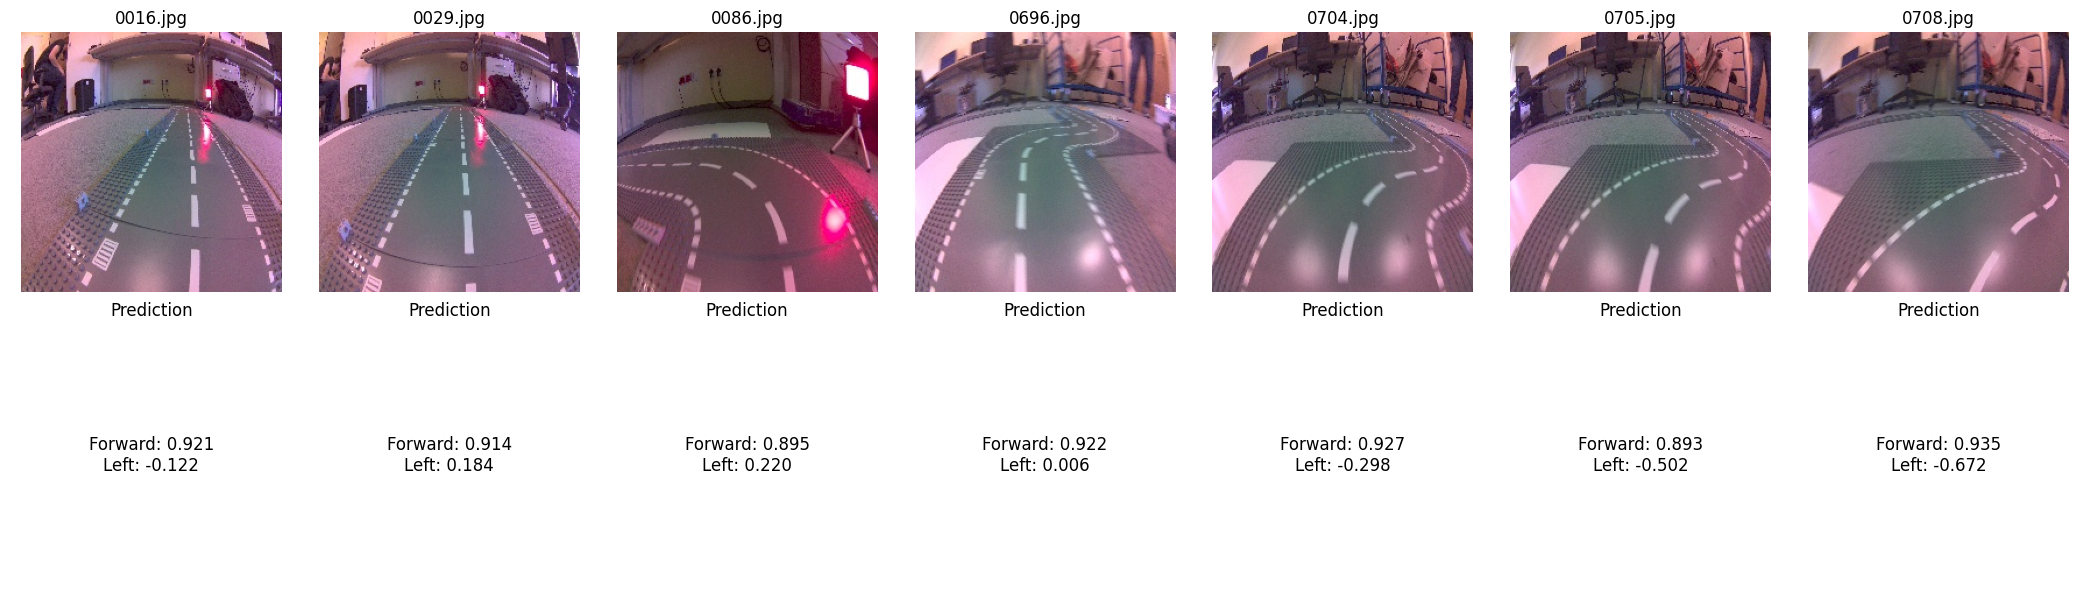


Predictions:
0016.jpg: Forward=0.921, Left=-0.122
0029.jpg: Forward=0.914, Left=0.184
0086.jpg: Forward=0.895, Left=0.220
0696.jpg: Forward=0.922, Left=0.006
0704.jpg: Forward=0.927, Left=-0.298
0705.jpg: Forward=0.893, Left=-0.502
0708.jpg: Forward=0.935, Left=-0.672


In [63]:
def predict_camera_images():
    """Function to predict on images in /content/camera/ directory (change if not on collab)"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load model
    model = ModifiedNvidiaNetwork()
    model.load_state_dict(torch.load('nvidia_preprocessing_clash1.pth', map_location=device))
    model.to(device)
    model.eval()

    # Get camera images
    camera_paths = glob("/content/camera/*.jpg")
    camera_paths.sort()

    print(f"Found {len(camera_paths)} images in /camera/")

    # Create visualization
    n_images = len(camera_paths)
    fig, axes = plt.subplots(2, n_images, figsize=(3*n_images, 6))
    if n_images == 1:
        axes = axes.reshape(2, 1)

    predictions = []

    for i, img_path in enumerate(camera_paths):
        # Load and preprocess image
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Use existing preprocess_image function from DrivingDataset
        dataset = DrivingDataset([], image_size=64, augment=False)
        processed = dataset.preprocess_image(image)

        with torch.no_grad():
            img_tensor = torch.FloatTensor(processed).unsqueeze(0).to(device)
            pred = model(img_tensor).cpu().numpy()[0]
            predictions.append(pred)

        # Show original image
        axes[0, i].imshow(image_rgb)
        axes[0, i].set_title(f'{Path(img_path).name}')
        axes[0, i].axis('off')

        # Show predictions
        forward, left = pred
        axes[1, i].text(0.5, 0.5, f'Forward: {forward:.3f}\nLeft: {left:.3f}',
                       ha='center', va='center', fontsize=12, transform=axes[1, i].transAxes)
        axes[1, i].set_title('Prediction')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

    print("\nPredictions:")
    for i, (path, pred) in enumerate(zip(camera_paths, predictions)):
        print(f"{Path(path).name}: Forward={pred[0]:.3f}, Left={pred[1]:.3f}")

# Run camera predictions
predict_camera_images()